# Test method for altering shape blob chooses to construct

Requires the modification of two inner functions within the topology:
- `hits_in_blob()`
- `energy_of_voxels_within_radius()`

First, lets create a track with an oblate blob

In [1]:
import sys,os,os.path
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'
import copy
import numpy as np
import pandas as pd
import networkx as nx

from invisible_cities.cities.components import track_blob_info_creator_extractor
from invisible_cities.io.hits_io        import load_hits
from invisible_cities.io.hits_io        import hits_from_df
from invisible_cities.core              import system_of_units as units
from invisible_cities.types.symbols     import HitEnergy
from invisible_cities.evm.event_model   import HitCollection
from invisible_cities.evm.event_model   import Cluster
from invisible_cities.evm.event_model   import Hit
from invisible_cities.types.ic_types    import xy
from invisible_cities.reco.paolina_functions import voxelize_hits
import invisible_cities.reco.paolina_functions as plf

from   matplotlib.animation import FuncAnimation
import matplotlib.pyplot    as     plt
import matplotlib.colors    as     colors
import matplotlib.cm        as     cm
from matplotlib.colors import Normalize

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def plot_voxels(df, base_vsize = 12):

    xs = df.X
    ys = df.Y
    zs = df.Z
    es = df.E

    the_hits = []
    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)
    
    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)
    
    vsizex = voxels[0].size[0]
    vsizey = voxels[0].size[1]
    vsizez = voxels[0].size[2]

    min_corner_x = min(v.X for v in voxels) - vsizex/2.
    min_corner_y = min(v.Y for v in voxels) - vsizey/2.
    min_corner_z = min(v.Z for v in voxels) - vsizez/2.

    
    x = [np.round(v.X/vsizex) for v in voxels]
    y = [np.round(v.Y/vsizey) for v in voxels]
    z = [np.round(v.Z/vsizez) for v in voxels]
    e = [v.E for v in voxels]

    x_min = int(min(x))
    y_min = int(min(y))
    z_min = int(min(z))

    x_max = int(max(x))
    y_max = int(max(y))
    z_max = int(max(z))

    VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
    #print(VOXELS.shape)

    # sort through the event set the "turn on" the hit voxels
    cmap = cm.viridis
    norm = Normalize(vmin=0, vmax=max(e))

    colors = np.empty(VOXELS.shape, dtype=object)
    for q in range(0,len(z)):
        VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
        colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

    # and plot everything
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    #a,b,c is spacing in mm needs an extra dim
    a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
    a = a*vsizex + min_corner_x
    b = b*vsizey + min_corner_y
    c = c*vsizez + min_corner_z

    # a, b, c are the corners of the voxels
    ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

    ax.set_xlabel('x (mm)')#,fontsize=16)
    ax.set_ylabel('y (mm)')#,fontsize=16)
    ax.set_zlabel('z (mm)')#,fontsize=16)


    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax)
    cb.set_label('Energy (keV)')

    fig.suptitle('voxelised_plot_two_tracks')

    #ax.view_init(-160, 90)

    #plt.show(fig)

def raw_plotter(q, evt, pitch = 15.55):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    fig.suptitle("rebinned in Z")
    plt.show(fig)



In [3]:
# make a track (it'll need to be much bigger than this obviously)
tr_1 = []
#for i in range(0, 5):
#    z_1 = np.random.uniform(low = 1 * units.mm, high = 20 * units.mm)
#    z_2 = np.random.uniform(low = 1 * units.mm, high = 20 * units.mm)
#    e_1 = np.random.uniform(low = 1, high = 20)
#    e_2 = np.random.uniform(low = 1, high = 20)
#    tr_1.append([0, 1, (9 * i + 1) * units.mm, 0 * units.mm, z_1, 1, e_1, e_1])
#    tr_1.append([0, 1, (9 * i + 1) * units.mm + 1, 30 * units.mm, z_2, 1, e_2, e_2])

# make a really explicit blob
# Create a spherical blob centered at (50, 50, 50) with radius 10 mm
center_x, center_y, center_z = 50 * units.mm, 50 * units.mm, 50 * units.mm
radius = 50 * units.mm
z_radius = 15 * units.mm
step = 10
# Create a tail for the blob
tail_length = 40  # Number of points in the tail
tail_direction = np.array([0.57735027, 0.57735027, 0.57735027])  # Unit vector for tail direction
tail_start = np.array([center_x, center_y, center_z]) + tail_direction * radius

for i in range(tail_length):
    perturbation = np.random.uniform(-0.5, 0.5, size=3) * units.mm  # Add some randomness to the tail
    current_position = tail_start + i * step * tail_direction + perturbation
    current_position[2] = np.round(current_position[2])  # Make Z position discrete
    energy = np.random.uniform(low=5, high=20)  # Random energy values for tail points
    tr_1.append([0, 1, current_position[0], current_position[1], current_position[2], 1, energy, energy])



for _ in range(500): 
    while True:
        x = np.random.uniform(center_x - radius, center_x + radius)
        y = np.random.uniform(center_y - radius, center_y + radius)
        z = np.random.uniform(center_z - z_radius, center_z + z_radius)
        z = np.round(z)  # Make Z position discrete
        distance_to_center = np.sqrt((x - center_x)**2 + (y - center_y)**2 + (z - center_z)**2)
        if distance_to_center <= radius:
            # Make points closer to the center more energetic with a smooth transition
            e = np.random.uniform(low=50, high=100) * (1 - distance_to_center / radius) + \
                np.random.uniform(low=5, high=50) * (distance_to_center / radius)
            tr_1.append([0, 1, x, y, z, 1, e, e])
            break

data = pd.DataFrame(tr_1, columns=['event', 'npeak', 'X', 'Y', 'Z', 'Q', 'E', 'Ep'])

display(data)

,event,npeak,X,Y,Z,Q,E,Ep
0,0,1,78.399280,79.226299,78.0,1,13.427170,13.427170
1,0,1,84.173238,84.448702,85.0,1,10.270024,10.270024
2,0,1,90.564959,90.853806,91.0,1,11.819217,11.819217
3,0,1,96.571503,95.825003,97.0,1,18.039899,18.039899
4,0,1,102.374671,101.870296,102.0,1,6.044358,6.044358
...,...,...,...,...,...,...,...,...
535,0,1,31.134528,7.263005,58.0,1,28.355040,28.355040
536,0,1,34.537774,62.365700,51.0,1,60.208922,60.208922
537,0,1,80.211713,16.297930,53.0,1,13.644914,13.644914
538,0,1,32.685817,34.753216,40.0,1,57.641886,57.641886


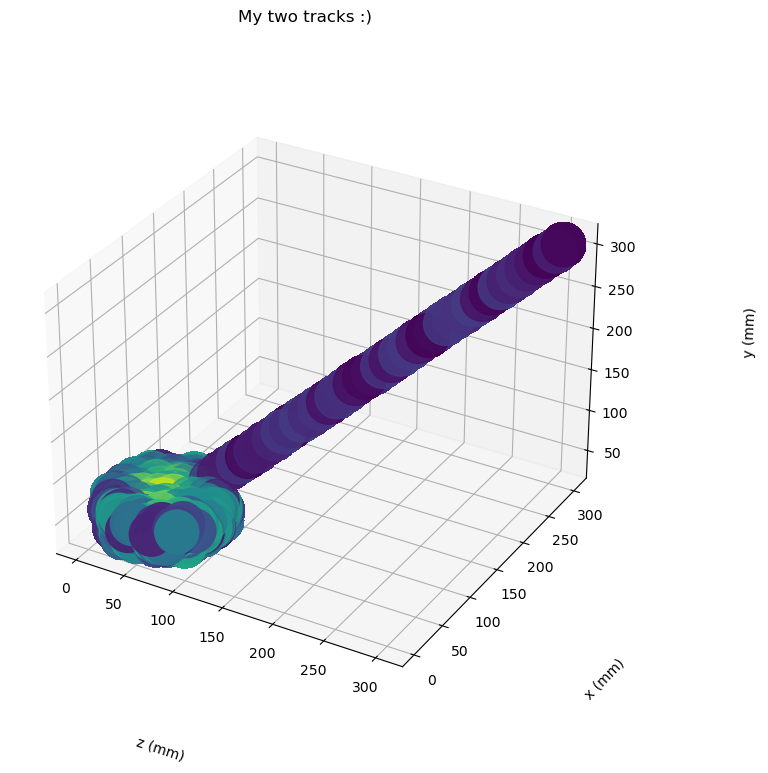

In [4]:
plt.ion()
ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
for Y, df in data.groupby(['Y']):
    ax.scatter(data.X, data.Y, data.Z, c=data.E, s=1000, label = f'{Y}')
ax.set_xlabel("z (mm)", labelpad=50)
ax.set_ylabel("x (mm)", labelpad=50)
ax.set_zlabel("y (mm)", labelpad=50)
plt.suptitle("My two tracks :)")

plt.show()

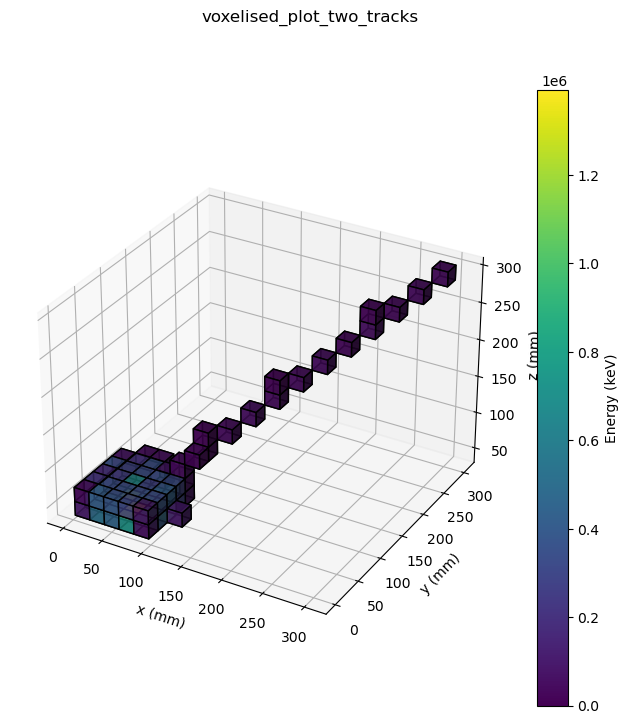

In [5]:
plot_voxels(data, base_vsize = 20)

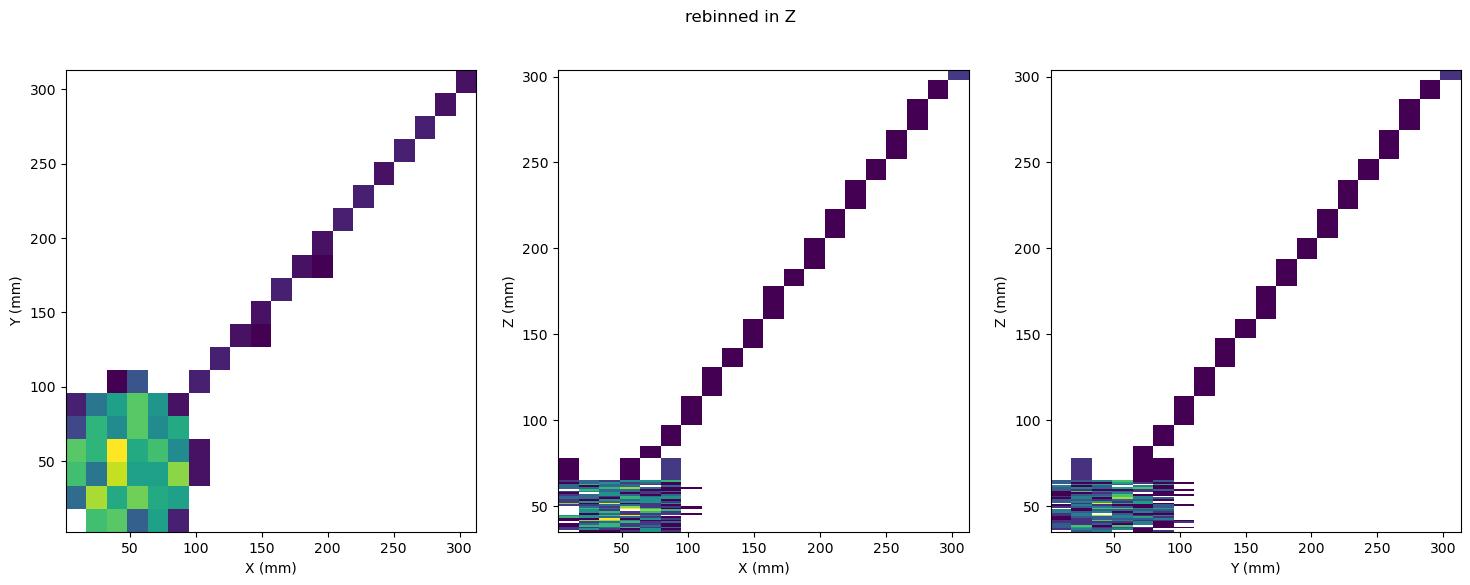

In [6]:
raw_plotter(data, 0)

Now, to take the normal blob method

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,22110.359108,488.933623,192,540,1,1.534306,2.261212,35.0,...,44.0,298.576178,298.341328,298.477384,8960.818932,62.205892,0.0,11.620849,11.590564,11.695652


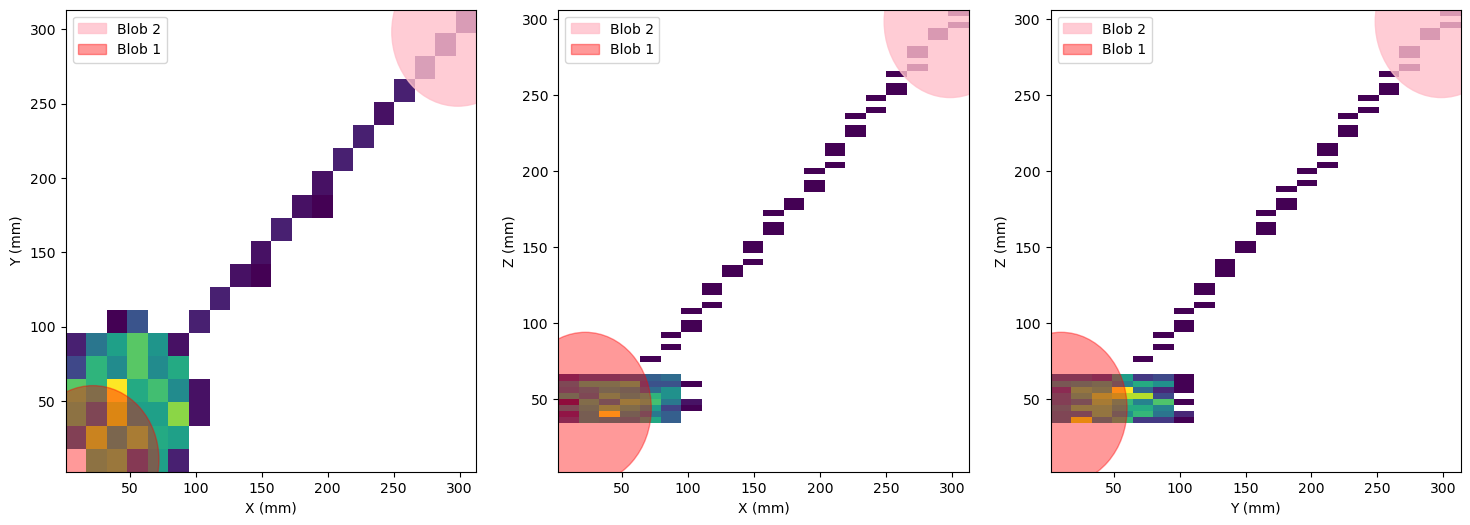

In [7]:
scan_radius = 75 * units.mm
blob_radius = 50 * units.mm

topological_creator = track_blob_info_creator_extractor((12 * units.mm, 12 * units.mm, 12 * units.mm),
                                                        False,
                                                        10 * units.keV,
                                                        3,
                                                        blob_radius,
                                                        1000000
                                                        )

hits_lol = hits_from_df(data)

df, track_hitc, out_of_map = topological_creator(hits_lol[0])
display(df)

from matplotlib.patches import Circle

q = data
pitch = 15.55
z_pitch = 4 # to deal with plotting


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
zz = np.arange(q.Y.min(), q.Y.max() + z_pitch, z_pitch)

axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

x_b1 = df.blob1_x
y_b1 = df.blob1_y
z_b1 = df.blob1_z

x_b2 = df.blob2_x
y_b2 = df.blob2_y
z_b2 = df.blob2_z
for ax, (x_data, y_data) in zip(axes, [(x_b2, y_b2), (x_b2, z_b2), (y_b2, z_b2)]):
    for x, y in zip(x_data, y_data):
        circle = Circle((x, y), radius=blob_radius, color='pink', alpha=0.8, label='Blob 2')
        ax.add_patch(circle)
    ax.legend()

for ax, (x_data, y_data) in zip(axes, [(x_b1, y_b1), (x_b1, z_b1), (y_b1, z_b1)]):
    for x, y in zip(x_data, y_data):
        circle = Circle((x, y), radius=blob_radius, color='red', alpha=0.4, label='Blob 1')
        ax.add_patch(circle)
    ax.legend()


# altering it (not old and dead)

In [13]:
from invisible_cities.reco                      import         paolina_functions as plf
from typing import Tuple, Callable, Sequence
from invisible_cities.core.system_of_units import mm
from invisible_cities.types.ic_types import types_dict_tracks
from invisible_cities.evm.event_model import BHit, Voxel
from networkx           import Graph
from typing import Dict


def distance_scale_Z(z_scale):

    def distance_Z(endpoint1, endpoint2, edge_attributes):
        '''
        Scale wrt Z
        '''
        distance = np.sqrt((endpoint1.X - endpoint2.X)**2 + (endpoint1.Y - endpoint2.Y)**2 + ((endpoint1.Z - endpoint2.Z) * z_scale)**2)
        return distance

    return distance_Z


def shortest_paths(track_graph : Graph, z_scale : [float, None]) -> Dict[Voxel, Dict[Voxel, float]]:
    """Compute shortest path lengths between all nodes in a weighted graph."""
    def voxel_pos(x):
        return x[0].pos.tolist()


    if z_scale is None:
        distances = dict(nx.all_pairs_dijkstra_path_length(track_graph, weight='distance'))
    else:
        z_scaler = distance_scale_Z(z_scale)
        distances = dict(nx.all_pairs_dijkstra_path_length(track_graph, weight=z_scaler))

    # sort the output so the result is reproducible
    distances = { v1 : {v2:d for v2, d in sorted(dmap.items(), key=voxel_pos)}
                  for v1, dmap in sorted(distances.items(), key=voxel_pos)}
    return distances


def find_highest_energy_node( track: Graph
                            , extreme : Voxel
                            , radius  : float) -> Tuple[Voxel, dict]:
    """Find the node with the highest associated energy in the track graph"""
    # we want to obtain the node information here, so have to flag data = True
    # and take first element
    # (energy information is encoded into node, for some reason)
    distances         = plf.shortest_paths(track)

    nodes_within_radius = [node for node in track.nodes if distances[extreme][node] <= radius]
    highest_energy_node = max(nodes_within_radius, key=lambda node: node.E)
    print(highest_energy_node)
    return highest_energy_node


def find_highest_encapsulating_node( track   : Graph
                                   , extreme : Voxel
                                   , big_radius    : float
                                   , small_radius  : float) -> Tuple[Voxel, dict]:
    '''
    Find the voxel within a big radius for which the most energy
    is captured within an equivalent smaller radius.
    '''
    distances = plf.shortest_paths(track)
    nodes_within_radius = [node for node in track.nodes if distances[extreme][node] <= big_radius]

    def energy_within_radius(node):
        return plf.energy_of_voxels_within_radius(distances[node], small_radius)

    highest_encapsulating_node = max(nodes_within_radius, key=energy_within_radius)
    extreme_node_energy        = plf.energy_of_voxels_within_radius(distances[extreme], small_radius)
    # if energy is significantly higher due to shifting, keep it, else return the original node
    print(energy_within_radius(highest_encapsulating_node))
    print(energy_within_radius(extreme))
    if energy_within_radius(highest_encapsulating_node) * 0.5 > energy_within_radius(extreme):
        print('highest node wins')
        return highest_encapsulating_node
    else:
        print('extreme node wins')
        return extreme

def blob_centre(voxel: Voxel) -> Tuple[float, float, float]:
    """Calculate the blob position, starting from the end-point voxel."""
    positions = [h.pos              for h in voxel.hits]
    energies  = [getattr(h, voxel.Etype) for h in voxel.hits]
    if sum(energies):
        bary_pos = np.average(positions, weights=energies, axis=0)
    # Consider the case where voxels are built without associated hits
    else:
        bary_pos = voxel.pos

    return bary_pos

def hits_in_blob(track_graph : Graph,
                 radius      : float,
                 extreme     : Voxel,
                 zscale      : float) -> Sequence[BHit]:
    """Returns the hits that belong to a blob."""
    distances         = shortest_paths(track_graph, zscale)
    dist_from_extreme = distances[extreme]
    blob_pos          = blob_centre(extreme)
    diag              = np.linalg.norm(extreme.size)

    blob_hits = []
    # First, consider only voxels at a certain distance from the end-point, along the track.
    # We allow for 1 extra contiguity, because this distance is calculated between
    # the centres of the voxels, and not the hits. In the second step we will refine the
    # selection, using the euclidean distance between the blob position and the hits.
    for v in track_graph.nodes():
        voxel_distance = dist_from_extreme[v]
        if voxel_distance < radius + diag:
            for h in v.hits:
                hit_distance = np.linalg.norm(blob_pos - h.pos)
                if hit_distance < radius:
                    blob_hits.append(h)

    return blob_hits

def blob_energies_hits_and_centres_altered( track_graph  : Graph
                                          , big_radius   : float
                                          , small_radius : [float, float]) -> Tuple[float, float, Sequence[BHit], Sequence[BHit], Tuple[float, float, float], Tuple[float, float, float]]:
    """Return the energies, the hits and the positions of the blobs.
       Does so with a double iteration method, first taking the extremes
       and defining an extreme radius around them to find the voxel with the
       largest energy, and redefining that as the central voxel.
       """
    zscale = small_radius[1] / small_radius[0] # should be xy radius / z radius
    distances = shortest_paths(track_graph, zscale)
    a, b, _   = plf.find_extrema_and_length(distances)

    # find the highest energy voxel in a radius
    #va_highE = find_highest_energy_node(track_graph, a, big_radius)
    #vb_highE = find_highest_energy_node(track_graph, b, big_radius)
    va_highE = find_highest_encapsulating_node(track_graph, a, big_radius, small_radius[1])
    vb_highE = find_highest_encapsulating_node(track_graph, b, big_radius, small_radius[1])
    # Select any node and check its attributes
    ha = hits_in_blob(track_graph, small_radius[1], va_highE, zscale)
    hb = hits_in_blob(track_graph, small_radius[1], vb_highE, zscale)

    voxels = list(track_graph.nodes())
    e_type = voxels[0].Etype
    Ea = sum(getattr(h, e_type) for h in ha)
    Eb = sum(getattr(h, e_type) for h in hb)

    # Consider the case where voxels are built without associated hits
    if len(ha) == 0 and len(hb) == 0 :
        Ea = plf.energy_of_voxels_within_radius(distances[va_highE], small_radius[1])
        Eb = plf.energy_of_voxels_within_radius(distances[vb_highE], small_radius[1])

    ca = plf.blob_centre(va_highE)
    cb = plf.blob_centre(vb_highE)

    if Eb > Ea:
        return (Eb, Ea, hb, ha, cb, ca)
    else:
        return (Ea, Eb, ha, hb, ca, cb)


# now lets think up the new functionality for determining the blob centre
def track_blob_info_creator_extractor_altered(vox_size         : Tuple[float, float, float],
                                      strict_vox_size  : bool                      ,
                                      energy_threshold : float                     ,
                                      min_voxels       : int                       ,
                                      scan_radius      : float                     ,
                                      blob_radius      : [float, float]            ,
                                      max_num_hits     : int
                                     ) -> Callable:
    """
    For a given paolina parameters returns a function that extract tracks / blob information from a HitCollection.

    Parameters
    ----------
    vox_size         : [float, float, float]
        (maximum) size of voxels for track reconstruction
    strict_vox_size  : bool
        if False allows per event adaptive voxel size,
        smaller of equal thatn vox_size
    energy_threshold : float
        if energy of end-point voxel is smaller
        the voxel will be dropped and energy redistributed to the neighbours
    min_voxels       : int
        after min_voxel number of voxels is reached no dropping will happen.
    blob_radius      : float
        radius of blob

    Returns
    ----------
    A function that from a given HitCollection returns a pandas DataFrame with per track information.
    """
    def create_extract_track_blob_info(hitc):
        df = pd.DataFrame(columns=list(types_dict_tracks.keys()))
        if len(hitc.hits) > max_num_hits:
            return df, hitc, True
        #track_hits is a new Hitcollection object that contains hits belonging to tracks, and hits that couldnt be corrected
        track_hitc = HitCollection(hitc.event, hitc.time)
        out_of_map = np.any(np.isnan([h.Ep for h in hitc.hits]))
        if out_of_map:
            #add nan hits to track_hits, the track_id will be -1
            track_hitc.hits.extend  ([h for h in hitc.hits if np.isnan   (h.Ep)])
            hits_without_nan       = [h for h in hitc.hits if np.isfinite(h.Ep)]
            #create new Hitcollection object but keep the name hitc
            hitc      = HitCollection(hitc.event, hitc.time)
            hitc.hits = hits_without_nan

        hit_energies = np.array([getattr(h, HitEnergy.Ep.value) for h in hitc.hits])

        if len(hitc.hits) > 0 and (hit_energies>0).any():
            voxels           = plf.voxelize_hits(hitc.hits, vox_size, strict_vox_size, HitEnergy.Ep)
            (    mod_voxels,
             dropped_voxels) = plf.drop_end_point_voxels(voxels, energy_threshold, min_voxels)

            for v in dropped_voxels:
                track_hitc.hits.extend(v.hits)

            tracks = plf.make_track_graphs(mod_voxels)
            tracks = sorted(tracks, key=plf.get_track_energy, reverse=True)

            vox_size_x = voxels[0].size[0]
            vox_size_y = voxels[0].size[1]
            vox_size_z = voxels[0].size[2]
            del(voxels)

            track_hits = []
            for c, t in enumerate(tracks, 0):
                tID = c
                
                energy = plf.get_track_energy(t)
                numb_of_hits   = len([h for vox in t.nodes() for h in vox.hits])
                numb_of_voxels = len(t.nodes())
                numb_of_tracks = len(tracks   )
                pos   = [h.pos for v in t.nodes() for h in v.hits]
                x, y, z = map(np.array, zip(*pos))
                r = np.sqrt(x**2 + y**2)

                e     = [h.Ep for v in t.nodes() for h in v.hits]
                ave_pos = np.average(pos, weights=e, axis=0)
                ave_r   = np.average(r  , weights=e, axis=0)
                distances = plf.shortest_paths(t)
                extr1, extr2, length = plf.find_extrema_and_length(distances)
                extr1_pos = extr1.XYZ
                extr2_pos = extr2.XYZ

                e_blob1, e_blob2, hits_blob1, hits_blob2, blob_pos1, blob_pos2 = blob_energies_hits_and_centres_altered(t, scan_radius, blob_radius)

                overlap = float(sum(h.Ep for h in set(hits_blob1).intersection(set(hits_blob2))))
                list_of_vars = [hitc.event, tID, energy, length, numb_of_voxels,
                                numb_of_hits, numb_of_tracks,
                                min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r),
                                *ave_pos, ave_r, *extr1_pos,
                                *extr2_pos, *blob_pos1, *blob_pos2,
                                e_blob1, e_blob2, overlap,
                                vox_size_x, vox_size_y, vox_size_z]

                df.loc[c] = list_of_vars

                for vox in t.nodes():
                    for hit in vox.hits:
                        hit.track_id = tID
                        track_hits.append(hit)

            #change dtype of columns to match type of variables
            df = df.apply(lambda x : x.astype(types_dict_tracks[x.name]))
            track_hitc.hits.extend(track_hits)
        return df, track_hitc, out_of_map

    return create_extract_track_blob_info

In [14]:
scan_radius = 75 * units.mm
blob_radius = (1 * units.mm, 50 * units.mm) # z first


topological_creator = track_blob_info_creator_extractor_altered((12 * units.mm, 12 * units.mm, 12 * units.mm),
                                                        False,
                                                        10 * units.keV,
                                                        3,
                                                        scan_radius,
                                                        blob_radius,
                                                        1000000
                                                        )

hits_lol = hits_from_df(data)

#track = topological_creator(hits_lol[0])
df, track_hitc, out_of_map = topological_creator(hits_lol[0])
display(df)
print(f'ENERGY of blob 1 with radius of XY: {blob_radius[1]}, Z: {blob_radius[0]}\n{df.eblob1.values[0]}')
print(f'ENERGY of blob 2 with radius of XY: {blob_radius[1]}, Z: {blob_radius[0]}\n{df.eblob2.values[0]}')

18940.020270185843
6419.856542587985
highest node wins
133.98524824110123
74.2033316245337
extreme node wins


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,22110.359108,488.933623,192,540,1,1.534306,2.261212,35.0,...,55.398635,298.576178,298.341328,298.477384,8613.677048,25.141393,0.0,11.620849,11.590564,11.695652


ENERGY of blob 1 with radius of XY: 50.0, Z: 1.0
8613.677047690271
ENERGY of blob 2 with radius of XY: 50.0, Z: 1.0
25.14139334424302


(0.0, 350.0)

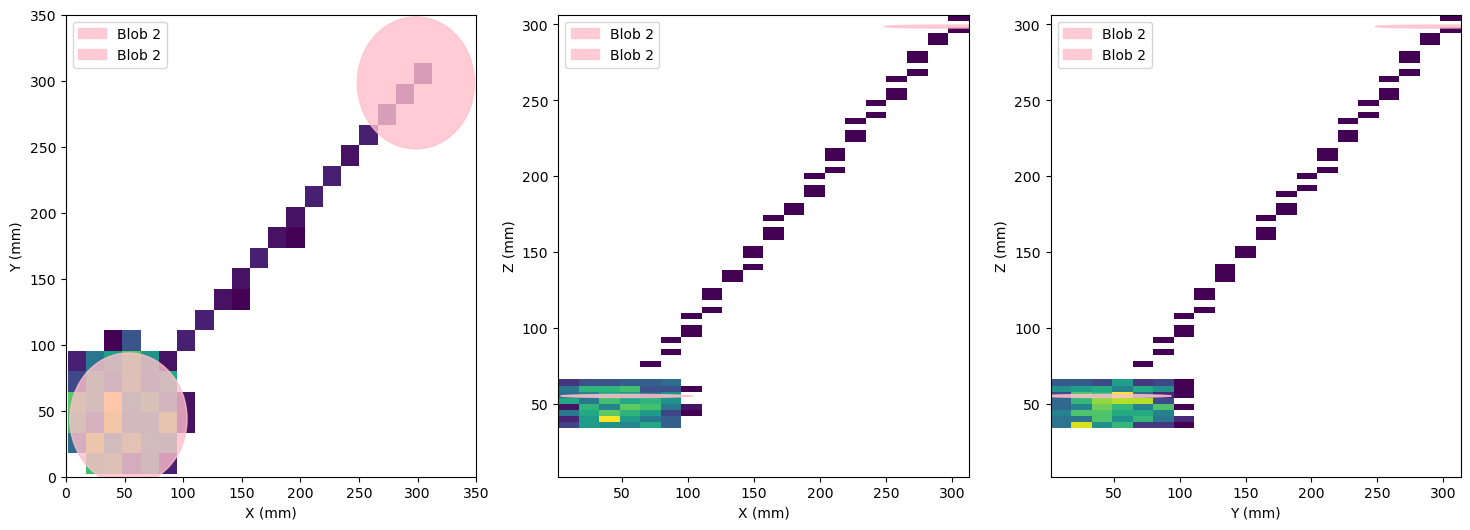

In [10]:
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse

q = data
pitch = 15.55
z_pitch = 4 # to deal with plotting


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
zz = np.arange(q.Y.min(), q.Y.max() + z_pitch, z_pitch)

axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

x_b1 = df.blob1_x
y_b1 = df.blob1_y
z_b1 = df.blob1_z

x_b2 = df.blob2_x
y_b2 = df.blob2_y
z_b2 = df.blob2_z
for ax, (x_data, y_data, br1, br2) in zip(axes, [(x_b2, y_b2, blob_radius[1], blob_radius[1]), (x_b2, z_b2, blob_radius[1], blob_radius[0]), (y_b2, z_b2, blob_radius[1], blob_radius[0])]):
    
    for x, y, br1, br2 in zip(x_data, y_data, [int(br1)], [int(br2)]):
        circle = Ellipse((x, y), width=br1*2, height=br2*2, color='pink', alpha=0.8, label='Blob 2')
        ax.add_patch(circle)
    ax.legend()

for ax, (x_data, y_data, br1, br2) in zip(axes, [(x_b1, y_b1, blob_radius[1], blob_radius[1]), (x_b1, z_b1, blob_radius[1], blob_radius[0]), (y_b1, z_b1, blob_radius[1], blob_radius[0])]):
    
    for x, y, br1, br2 in zip(x_data, y_data, [int(br1)], [int(br2)]):
        circle = Ellipse((x, y), width=br1*2, height=br2*2, color='pink', alpha=0.8, label='Blob 2')
        ax.add_patch(circle)
    ax.legend()

#for ax, (x_data, y_data) in zip(axes, [(x_b1, y_b1), (x_b1, z_b1), (y_b1, z_b1)]):
#    for x, y in zip(x_data, y_data):
#        circle = Circle((x, y), radius=blob_radius, color='red', alpha=0.4, label='Blob 1')
#        ax.add_patch(circle)
#    ax.legend()

axes[0].set_xlim(0, 350)
axes[0].set_ylim(0, 350)


Graph with 197 nodes and 1408 edges
[Voxel(7.881156325812363, 30.372203752467236, 40.84782608695365, E=161.87055566413184), Voxel(7.881156325812363, 30.372203752467236, 52.54347826086696, E=77.63930477234817), Voxel(7.881156325812363, 30.372203752467236, 64.23913043478026, E=58.78146479549457), Voxel(7.881156325812363, 42.02544671133065, 40.84782608695365, E=17.902809396800688), Voxel(7.881156325812363, 42.02544671133065, 52.54347826086696, E=173.46630312160343), Voxel(7.881156325812363, 42.02544671133065, 64.23913043478026, E=127.73731168142923), Voxel(7.881156325812363, 53.67868967019407, 52.54347826086696, E=89.04541790150506), Voxel(7.881156325812363, 65.33193262905749, 40.84782608695365, E=34.61207646141155), Voxel(7.881156325812363, 65.33193262905749, 52.54347826086696, E=151.60972595935854), Voxel(7.881156325812363, 76.9851755879209, 40.84782608695365, E=46.722956385908944), Voxel(7.881156325812363, 76.9851755879209, 52.54347826086696, E=41.542303608248886), Voxel(7.881156325812

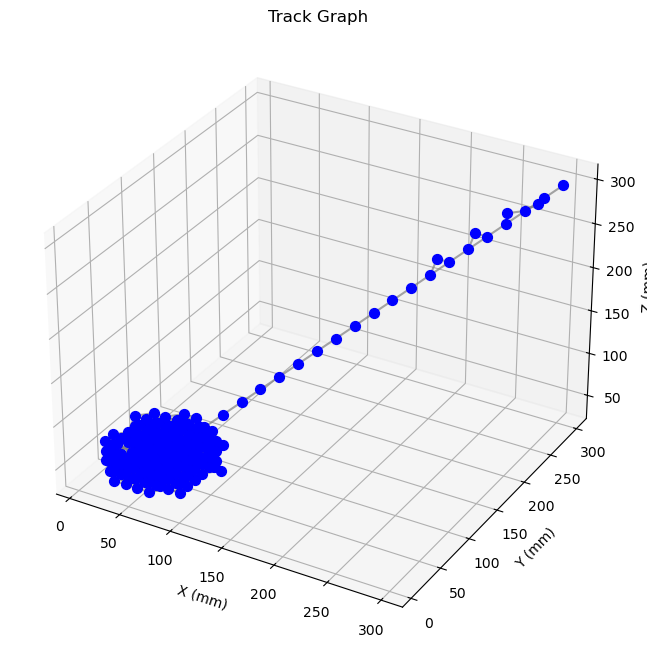

In [ ]:
print(track)
print(track.nodes)
print(track.edges)
print("Nodes in the track graph:")
import matplotlib.pyplot as plt

# Extract node positions
node_positions = {node: (node.X, node.Y, node.Z) for node in track.nodes}

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot nodes
for node in track.nodes:
    ax.scatter(node.X, node.Y, node.Z, c='blue', s=50, label='Node')

# Plot edges
for edge in track.edges:
    node1, node2 = edge
    x_coords = [node1.X, node2.X]
    y_coords = [node1.Y, node2.Y]
    z_coords = [node1.Z, node2.Z]
    ax.plot(x_coords, y_coords, z_coords, c='gray', alpha=0.7)

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
plt.title("Track Graph")
plt.show()

In [ ]:
dsc1 = distance_scale_Z(1)
dsc2 = distance_scale_Z(2)

first_three_nodes = list(track.nodes)[:3]
print(first_three_nodes)
next(iter(track.nodes))

node0 = Voxel(0, 0, 0, E = 0, size = 0)
node1 = Voxel(1, 1, 1, E = 0, size = 0)


distances_1 = dsc1(node0, node1, 'None')
distances_2 = dsc2(node0, node1, 'None')

print(distances_1)
print(distances_1 == np.sqrt(3)) # sqrt((1^2)*3)
print(distances_2)
print(distances_2 == np.sqrt(6)) # sqrt((1^2)*2 + (2^2)^2)


[Voxel(7.881156325812363, 30.372203752467236, 40.84782608695365, E=161.87055566413184), Voxel(7.881156325812363, 30.372203752467236, 52.54347826086696, E=77.63930477234817), Voxel(7.881156325812363, 30.372203752467236, 64.23913043478026, E=58.78146479549457)]
1.7320508075688772
True
2.449489742783178
True


## altering it (old and dead)

In [13]:
from invisible_cities.reco                      import         paolina_functions as plf
from typing import Tuple, Callable, Sequence
from invisible_cities.core.system_of_units import mm
from invisible_cities.types.ic_types import types_dict_tracks
from invisible_cities.evm.event_model import BHit, Voxel
from networkx           import Graph
from typing import Dict

def energy_of_voxels_within_radius(distances : Dict[Voxel, float], radius : [float, float]) -> float:
    return sum(v.E for (v, d) in distances.items() if d < radius)


def find_highest_energy_node( track: Graph
                            , extreme : Voxel
                            , radius  : float) -> Tuple[Voxel, dict]:
    """Find the node with the highest associated energy in the track graph"""
    # we want to obtain the node information here, so have to flag data = True
    # and take first element
    # (energy information is encoded into node, for some reason)
    distances         = plf.shortest_paths(track)

    nodes_within_radius = [node for node in track.nodes if distances[extreme][node] <= radius]
    highest_energy_node = max(nodes_within_radius, key=lambda node: node.E)
    #print(highest_energy_node)
    return highest_energy_node

def find_highest_encapsulating_node( track   : Graph
                                   , extreme : Voxel
                                   , big_radius    : float
                                   , small_radius  : float) -> Tuple[Voxel, dict]:
    '''
    Find the voxel within a big radius for which the most energy
    is captured within an equivalent smaller radius.
    '''
    distances = plf.shortest_paths(track)
    nodes_within_radius = [node for node in track.nodes if distances[extreme][node] <= big_radius]
    def energy_within_radius(node):
        return energy_of_voxels_within_radius(distances[node], small_radius)

    highest_encapsulating_node = max(nodes_within_radius, key=energy_within_radius)
    return highest_encapsulating_node


def hits_in_blob(track_graph : Graph,
                 radius      : Tuple[float, float],
                 extreme     : Voxel) -> Sequence[BHit]:
    """Returns the hits that belong to a blob."""
    print(track_graph.nodes)
    print(extreme)
    
    distances         = plf.shortest_paths(track_graph)
    dist_from_extreme = distances[extreme]
    blob_pos          = plf.blob_centre(extreme)
    diag              = np.linalg.norm(extreme.size)

    

    blob_hits = []
    # First, consider only voxels at a certain distance from the end-point, along the track.
    # We allow for 1 extra contiguity, because this distance is calculated between
    # the centres of the voxels, and not the hits. In the second step we will refine the
    # selection, using the euclidean distance between the blob position and the hits.
    for v in track_graph.nodes():
        voxel_distance = dist_from_extreme[v]
        if voxel_distance < radius + diag:
            for h in v.hits:
                hit_distance = np.linalg.norm(blob_pos - h.pos)
                if hit_distance < radius:
                    blob_hits.append(h)

    return blob_hits

def energy_of_voxels_within_radius(distances : Dict[Voxel, float], radius : float) -> float:
    return sum(v.E for (v, d) in distances.items() if d < radius)


def blob_energies_hits_and_centres_altered( track_graph  : Graph
                                          , big_radius   : float
                                          , small_radius :Tuple[float, float]) -> Tuple[float, float, Sequence[BHit], Sequence[BHit], Tuple[float, float, float], Tuple[float, float, float]]:
    """Return the energies, the hits and the positions of the blobs.
       Does so with a double iteration method, first taking the extremes
       and defining an extreme radius around them to find the voxel with the
       largest energy, and redefining that as the central voxel.

       Small radius consists of two radii:
       Z radius
       XY radius

       The Z radius is scaled wrt the XY radius
       
       eg: Z radius - 35, XY radius - 50, scale factor - 0.7

       We only do this for hit and energy calculations, at the moment doing it for the highest_encapsulating_node is
       slightly too complex and my brain is melting
       """
    
    # reshape the track such that Z axis is rescaled given a factor relative to XY
    # eg 50mm XY radius, 35mm Z radius should be 35/50 for all Z components, right?


    distances = plf.shortest_paths(track_graph)
    a, b, _   = plf.find_extrema_and_length(distances)

    # find the highest energy voxel in a radius
    #va_highE = find_highest_energy_node(track_graph, a, big_radius)
    #vb_highE = find_highest_energy_node(track_graph, b, big_radius)

    # no scaling applied in this step as the scaling requires the offset to be known.
    va_highE = find_highest_encapsulating_node(track_graph, a, big_radius, small_radius[1])
    vb_highE = find_highest_encapsulating_node(track_graph, b, big_radius, small_radius[1])

    # implement scale factor
    scale_factor = small_radius[1] / small_radius[0]

    # two new graphs for each blob, offset removed and scaled
    scaled_track_graph_a = copy.deepcopy(track_graph)
    
    for node in scaled_track_graph_a.nodes:
        node.X -= va_highE.X
        node.Y -= va_highE.Y
        node.Z -= va_highE.Z
    
        for h in node.hits:
            
            h.X = h.X - va_highE.X
            h.Y = h.Y - va_highE.Y
            h.Z = h.Z - va_highE.Z

    #a_voxel = Voxel(va_highE.X - va_highE.X, va_highE.Y - va_highE.Y, va_highE.Z - va_highE.Z, E = va_highE.E, size = va_highE.size)
    a_voxel = Voxel(0.0, 0.0, 0.0, E=va_highE.E, size = va_highE.size)

    
    for node in scaled_track_graph_a.nodes:
        
        node.Z *= scale_factor
        
        for h in node.hits:
            h.Z *= scale_factor

    scale_distances_a = plf.shortest_paths(scaled_track_graph_a)
    a_scale, _, _     = plf.find_extrema_and_length(scale_distances_a)
    va_highE_scale    = find_highest_encapsulating_node(scaled_track_graph_a, a_scale, big_radius, small_radius[1])

    #a, b, _ = plf.find_extrema_and_length(scale_distances_a)
    #va_highE_scaled = find_highest_encapsulating_node(scaled_track_graph_a, a, big_radius, small_radius[1])
    #print(f'highest energy voxel scaled: {va_highE_scaled}')



    # two new graphs for each blob, offset removed and scaled
    scaled_track_graph_b = copy.deepcopy(track_graph)

    print(f'{list(track_graph.nodes)[0].hits[0]}')
    print(f'{list(scaled_track_graph_b.nodes)[0].hits[0]}')
    #print(f'{[v for v in a.hits for a in track_graph.nodes]}')
    for node in scaled_track_graph_b.nodes:
        node.X -= vb_highE.X
        node.Y -= vb_highE.Y
        node.Z -= vb_highE.Z

        for h in node.hits:
            #print('=' * 20)
            #print('=' * 20)
            #print(h.X)
            h.X = h.X - vb_highE.X
            h.Y = h.Y - vb_highE.Y
            h.Z = h.Z - vb_highE.Z
            #print(h.X)
            #print('=' * 20)
            #print('=' * 20)
    for node in scaled_track_graph_b.nodes:
        
        node.Z *= scale_factor

        for h in node.hits:
            h.Z *= scale_factor
    print('=' * 20)
    print('=' * 20)
    print(f'{list(track_graph.nodes)[0].hits[0]}')
    print(f'{list(scaled_track_graph_b.nodes)[0].hits[0]}')
    #print('pre-scaling track graphs')
    #print(f'{[v for v in a.hits for a in track_graph.nodes]}')

    #print('scaled track graphs')
    #print(f'{[v for v in a.hits for a in scaled_track_graph_b.nodes]}')
    scale_distances_b = plf.shortest_paths(scaled_track_graph_b)
    _, b_scale, _     = plf.find_extrema_and_length(scale_distances_b)
    vb_highE_scale    = find_highest_encapsulating_node(scaled_track_graph_b, b_scale, big_radius, small_radius[1])

    import matplotlib.pyplot as plt

    # Plot all the voxels for the original track_graph
    plt.figure(figsize=(30, 12))
    plt.subplot(1, 2, 1)
    for node in track_graph.nodes:
        plt.scatter(node.X, node.Y, c='lightblue', s=50)
    plt.title("Original Track Graph")
    plt.xlabel("X")
    plt.ylabel("Y")

    # Plot all the voxels for the scaled_track_graph_a
    plt.subplot(1, 2, 2)
    for node in scaled_track_graph_a.nodes:
        plt.scatter(node.X, node.Y, c='lightgreen', s=50)
    plt.title("Scaled Track Graph A")
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.show()

    raw_plotter([h for v in track_graph.nodes for h in v.hits], 0, show = True)
    print(f'are the hits the same?{[v for v in a.hits for a in track_graph.nodes]==[v for v in a.hits for a in scaled_track_graph_b.nodes]}')

    # Select any node and check its attributes
    ha = hits_in_blob(scaled_track_graph_a, small_radius[1], va_highE_scale)
    hb = hits_in_blob(scaled_track_graph_b, small_radius[1], vb_highE_scale)

    print(len(ha))
    print(ha[0])
    print(len(hb))
    

    voxels_a = list(scaled_track_graph_a.nodes())
    voxels_b = list(scaled_track_graph_b.nodes())
    e_type_a = voxels_a[0].Etype
    e_type_b = voxels_b[0].Etype
    Ea = sum(getattr(h, e_type_a) for h in ha)
    Eb = sum(getattr(h, e_type_b) for h in hb)

    # Consider the case where voxels are built without associated hits
    if len(ha) == 0 and len(hb) == 0 :
        Ea = energy_of_voxels_within_radius(scale_distances_a[a_voxel], small_radius)
        Eb = energy_of_voxels_within_radius(scale_distances_b[b_voxel], small_radius)

    # no need for scaling here
    ca = plf.blob_centre(va_highE)
    cb = plf.blob_centre(vb_highE)

    if Eb > Ea:
        return (Eb, Ea, hb, ha, cb, ca)
    else:
        return (Ea, Eb, ha, hb, ca, cb)


# now lets think up the new functionality for determining the blob centre
def track_blob_info_creator_extractor_altered(vox_size         : Tuple[float, float, float],
                                      strict_vox_size  : bool                      ,
                                      energy_threshold : float                     ,
                                      min_voxels       : int                       ,
                                      scan_radius      : float                     ,
                                      blob_radius      : [float, float]            ,
                                      max_num_hits     : int
                                     ) -> Callable:
    """
    For a given paolina parameters returns a function that extract tracks / blob information from a HitCollection.

    Parameters
    ----------
    vox_size         : [float, float, float]
        (maximum) size of voxels for track reconstruction
    strict_vox_size  : bool
        if False allows per event adaptive voxel size,
        smaller of equal thatn vox_size
    energy_threshold : float
        if energy of end-point voxel is smaller
        the voxel will be dropped and energy redistributed to the neighbours
    min_voxels       : int
        after min_voxel number of voxels is reached no dropping will happen.
    blob_radius      : float
        radius of blob

    Returns
    ----------
    A function that from a given HitCollection returns a pandas DataFrame with per track information.
    """
    def create_extract_track_blob_info(hitc):
        df = pd.DataFrame(columns=list(types_dict_tracks.keys()))
        if len(hitc.hits) > max_num_hits:
            return df, hitc, True
        #track_hits is a new Hitcollection object that contains hits belonging to tracks, and hits that couldnt be corrected
        track_hitc = HitCollection(hitc.event, hitc.time)
        out_of_map = np.any(np.isnan([h.Ep for h in hitc.hits]))
        if out_of_map:
            #add nan hits to track_hits, the track_id will be -1
            track_hitc.hits.extend  ([h for h in hitc.hits if np.isnan   (h.Ep)])
            hits_without_nan       = [h for h in hitc.hits if np.isfinite(h.Ep)]
            #create new Hitcollection object but keep the name hitc
            hitc      = HitCollection(hitc.event, hitc.time)
            hitc.hits = hits_without_nan

        hit_energies = np.array([getattr(h, HitEnergy.Ep.value) for h in hitc.hits])

        if len(hitc.hits) > 0 and (hit_energies>0).any():
            voxels           = plf.voxelize_hits(hitc.hits, vox_size, strict_vox_size, HitEnergy.Ep)
            (    mod_voxels,
             dropped_voxels) = plf.drop_end_point_voxels(voxels, energy_threshold, min_voxels)

            for v in dropped_voxels:
                track_hitc.hits.extend(v.hits)

            tracks = plf.make_track_graphs(mod_voxels)
            tracks = sorted(tracks, key=plf.get_track_energy, reverse=True)

            vox_size_x = voxels[0].size[0]
            vox_size_y = voxels[0].size[1]
            vox_size_z = voxels[0].size[2]
            del(voxels)

            track_hits = []
            for c, t in enumerate(tracks, 0):
                tID = c
                energy = plf.get_track_energy(t)
                numb_of_hits   = len([h for vox in t.nodes() for h in vox.hits])
                numb_of_voxels = len(t.nodes())
                numb_of_tracks = len(tracks   )
                pos   = [h.pos for v in t.nodes() for h in v.hits]
                x, y, z = map(np.array, zip(*pos))
                r = np.sqrt(x**2 + y**2)

                e     = [h.Ep for v in t.nodes() for h in v.hits]
                ave_pos = np.average(pos, weights=e, axis=0)
                ave_r   = np.average(r  , weights=e, axis=0)
                distances = plf.shortest_paths(t)
                extr1, extr2, length = plf.find_extrema_and_length(distances)
                extr1_pos = extr1.XYZ
                extr2_pos = extr2.XYZ

                e_blob1, e_blob2, hits_blob1, hits_blob2, blob_pos1, blob_pos2 = blob_energies_hits_and_centres_altered(t, scan_radius, blob_radius)

                overlap = float(sum(h.Ep for h in set(hits_blob1).intersection(set(hits_blob2))))
                list_of_vars = [hitc.event, tID, energy, length, numb_of_voxels,
                                numb_of_hits, numb_of_tracks,
                                min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r),
                                *ave_pos, ave_r, *extr1_pos,
                                *extr2_pos, *blob_pos1, *blob_pos2,
                                e_blob1, e_blob2, overlap,
                                vox_size_x, vox_size_y, vox_size_z]

                df.loc[c] = list_of_vars

                for vox in t.nodes():
                    for hit in vox.hits:
                        hit.track_id = tID
                        track_hits.append(hit)

            #change dtype of columns to match type of variables
            df = df.apply(lambda x : x.astype(types_dict_tracks[x.name]))
            track_hitc.hits.extend(track_hits)
        return df, track_hitc, out_of_map

    return create_extract_track_blob_info

<Hit : npeak = 1.0 z = 54.0 XYpeak = -1000, -1000 E = 33.07618104996526 Ec = -1 Ep = 33.07618104996526 trackid = -1 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=9.528833453014386, y=24.984762149854088) 3dHit = Hit(9.528833453014386, 24.984762149854088, 54.0, E=33.07618104996526)  > >
<Hit : npeak = 1.0 z = 54.0 XYpeak = -1000, -1000 E = 33.07618104996526 Ec = -1 Ep = 33.07618104996526 trackid = -1 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=9.528833453014386, y=24.984762149854088) 3dHit = Hit(9.528833453014386, 24.984762149854088, 54.0, E=33.07618104996526)  > >
<Hit : npeak = 1.0 z = 54.0 XYpeak = -1000, -1000 E = 33.07618104996526 Ec = -1 Ep = 33.07618104996526 trackid = -1 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=9.528833453014386, y=24.984762149854088) 3dHit = Hit(9.528833453014386, 24.984762149854088, 54.0, E=33.07618104996526)  > >
<Hit : npeak = 1.0 z = -15679.89130434798 XYpeak = -1000, -1000 E = 33.07618104996526 Ec = -1 Ep = 3

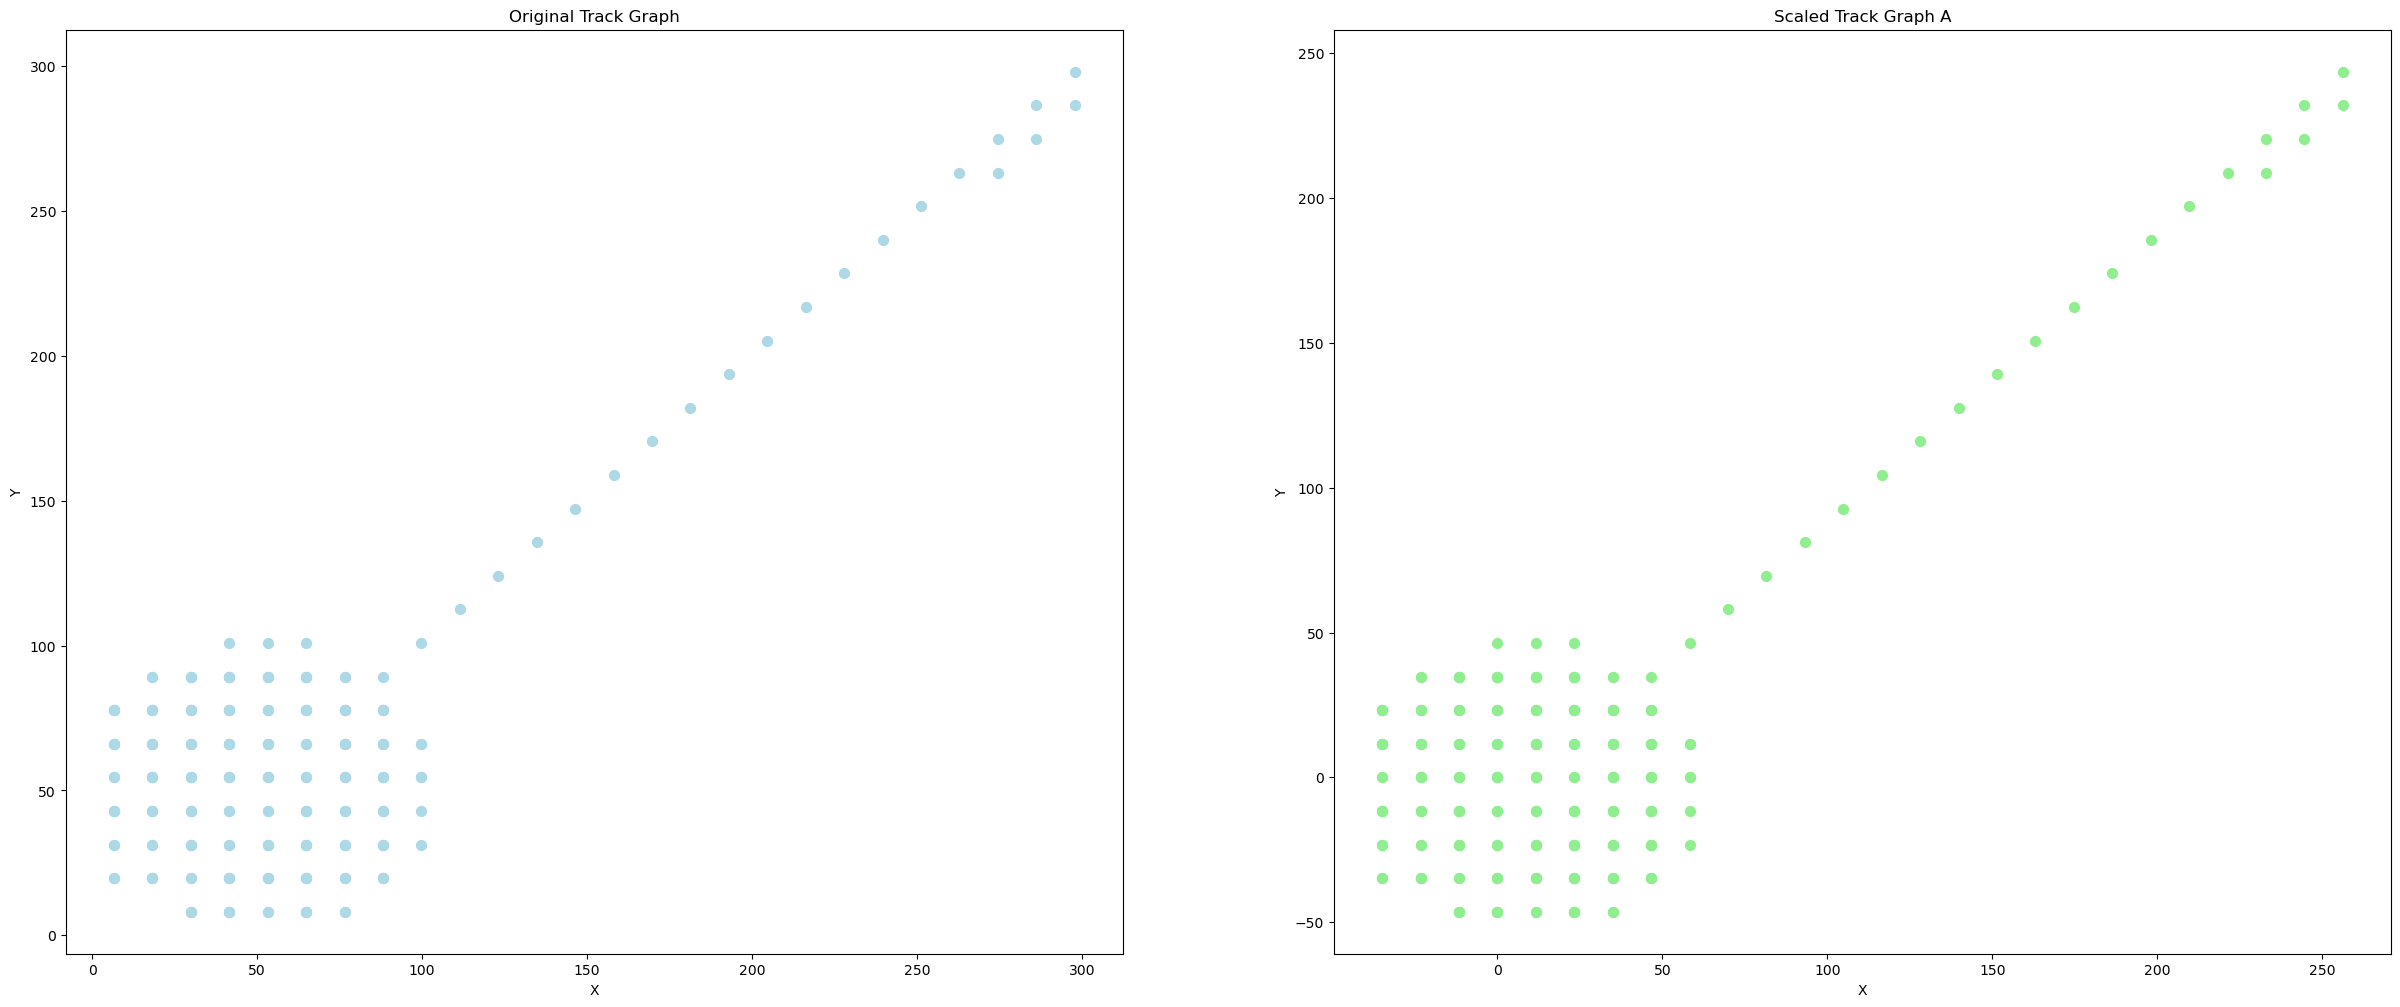

AttributeError: 'list' object has no attribute 'X'

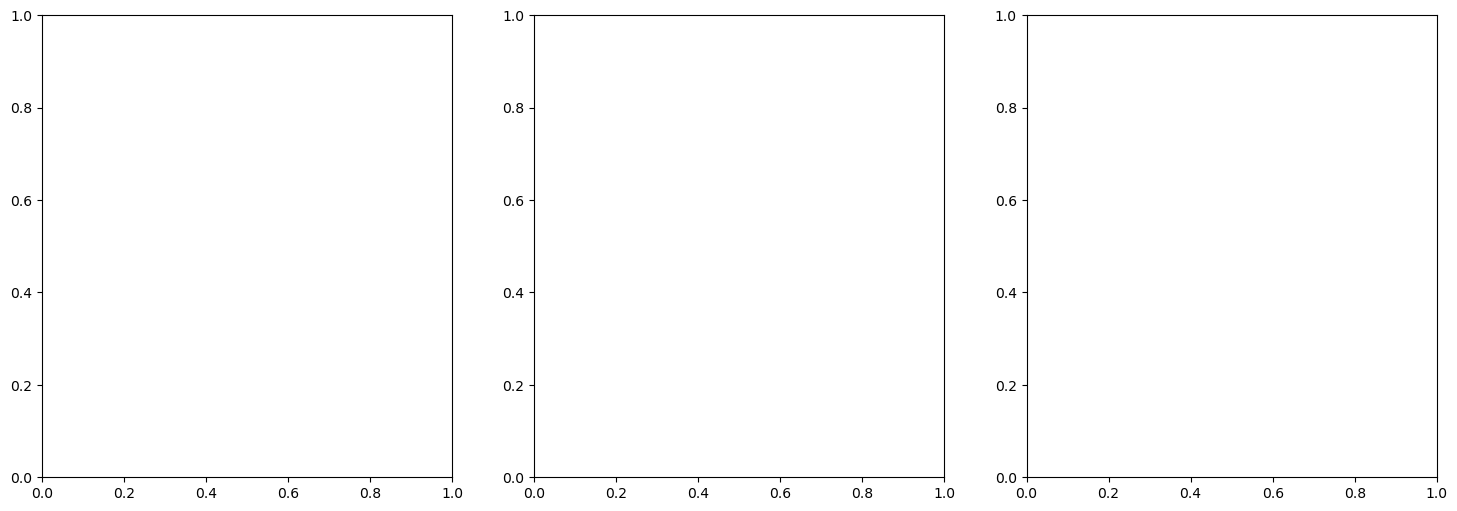

In [14]:
scan_radius = 75 * units.mm
blob_radius = (1 * units.mm, 75 * units.mm)


topological_creator = track_blob_info_creator_extractor_altered((12 * units.mm, 12 * units.mm, 12 * units.mm),
                                                        False,
                                                        10 * units.keV,
                                                        3,
                                                        scan_radius,
                                                        blob_radius,
                                                        1000000
                                                        )

hits_lol = hits_from_df(data)

df, track_hitc, out_of_map = topological_creator(hits_lol[0])
display(df)
print(f'ENERGY of blob 1 with radius of XY: {blob_radius[1]}, Z: {blob_radius[0]}\n{df.eblob1.values[0]}')
print(f'ENERGY of blob 2 with radius of XY: {blob_radius[1]}, Z: {blob_radius[0]}\n{df.eblob2.values[0]}')

pandas.core.frame.DataFrame

(0.0, 350.0)

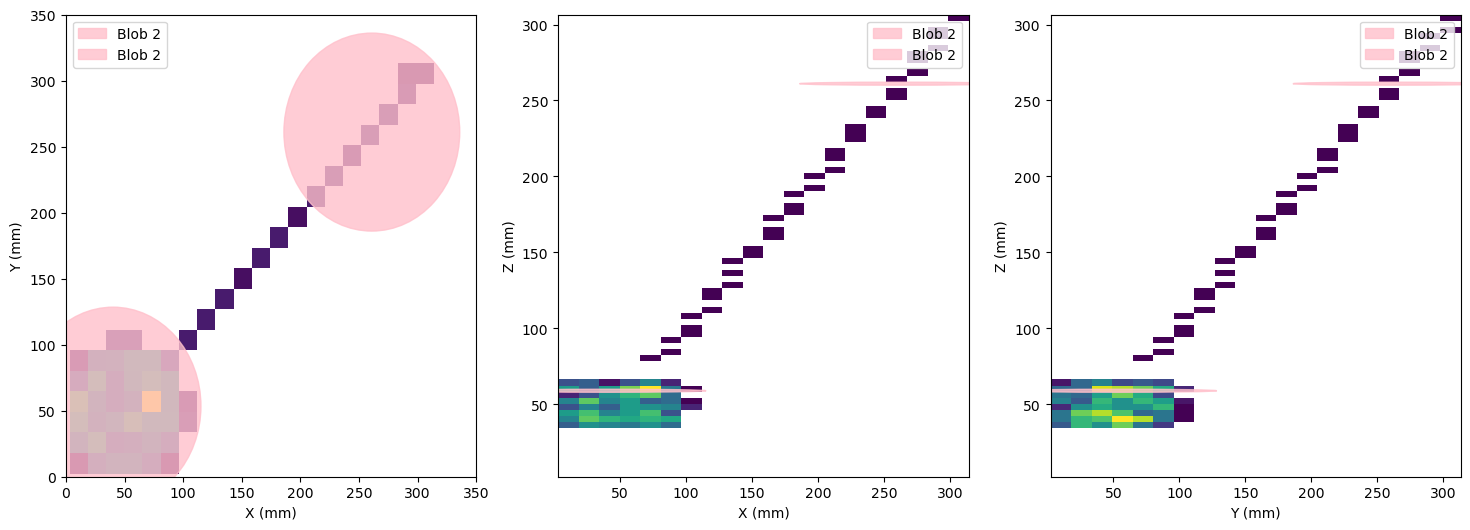

In [147]:
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse

q = data
pitch = 15.55
z_pitch = 4 # to deal with plotting


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
zz = np.arange(q.Y.min(), q.Y.max() + z_pitch, z_pitch)

axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

x_b1 = df.blob1_x
y_b1 = df.blob1_y
z_b1 = df.blob1_z

x_b2 = df.blob2_x
y_b2 = df.blob2_y
z_b2 = df.blob2_z
for ax, (x_data, y_data, br1, br2) in zip(axes, [(x_b2, y_b2, blob_radius[1], blob_radius[1]), (x_b2, z_b2, blob_radius[1], blob_radius[0]), (y_b2, z_b2, blob_radius[1], blob_radius[0])]):
    
    for x, y, br1, br2 in zip(x_data, y_data, [int(br1)], [int(br2)]):
        circle = Ellipse((x, y), width=br1*2, height=br2*2, color='pink', alpha=0.8, label='Blob 2')
        ax.add_patch(circle)
    ax.legend()

for ax, (x_data, y_data, br1, br2) in zip(axes, [(x_b1, y_b1, blob_radius[1], blob_radius[1]), (x_b1, z_b1, blob_radius[1], blob_radius[0]), (y_b1, z_b1, blob_radius[1], blob_radius[0])]):
    
    for x, y, br1, br2 in zip(x_data, y_data, [int(br1)], [int(br2)]):
        circle = Ellipse((x, y), width=br1*2, height=br2*2, color='pink', alpha=0.8, label='Blob 2')
        ax.add_patch(circle)
    ax.legend()

#for ax, (x_data, y_data) in zip(axes, [(x_b1, y_b1), (x_b1, z_b1), (y_b1, z_b1)]):
#    for x, y in zip(x_data, y_data):
#        circle = Circle((x, y), radius=blob_radius, color='red', alpha=0.4, label='Blob 1')
#        ax.add_patch(circle)
#    ax.legend()

axes[0].set_xlim(0, 350)
axes[0].set_ylim(0, 350)


In [10]:
def raw_plotter(q, evt, pitch = 15.55, show = False):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    zz_diff = np.diff(zz)
    zz_padded = []
    for i, z in enumerate(zz[:-1]):
        zz_padded.append(z)
        if zz_diff[i] > 4:
            zz_padded.extend(np.arange(z + 4, zz[i + 1], 4))
    zz_padded.append(zz[-1])
    zz = np.array(zz_padded)

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    fig.suptitle(f"evt {evt}")
    if show:
        plt.show(fig)

In [ ]:
raw_plotter()